In [1]:
import warnings
#スクリプト実行時に表示される警告メッセージを制御
warnings.filterwarnings("ignore") 

import os
#tokenizerライブラリ使用時の並列処理を抑制
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import numpy as np

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([1-t, t])
            sentences.append(line[1:].strip())
            
    return np.array(labels), sentences

train_labels, train_sentences = read_data('mc_train_data_jp.txt')
dev_labels, dev_sentences = read_data('mc_dev_data_jp.txt')
test_labels, test_sentences = read_data('mc_test_data_jp.txt')

In [3]:
import spacy

def tokenise(sentence):
    nlp = spacy.load("ja_ginza")
    doc = nlp(sentence)
    tokens = [token.text for token in doc]
    filtered_tokens = [token.text for token in doc if token.dep_ not in ("aux")]
    return filtered_tokens

train_tokenised = [tokenise(sentence) for sentence in train_sentences]
dev_tokenised = [tokenise(sentence) for sentence in dev_sentences]
test_tokenised = [tokenise(sentence) for sentence in test_sentences]

In [4]:
from lambeq import BobcatParser
import japanize_matplotlib

parser = BobcatParser(verbose='suppress')

raw_train_diagrams = []
raw_dev_diagrams = []
raw_test_diagrams = []

for i in range(len(train_tokenised)):
    raw_train_diagrams.append(parser.sentence2diagram(train_tokenised[i], tokenised=True))
for i in range(len(dev_tokenised)):
    raw_dev_diagrams.append(parser.sentence2diagram(dev_tokenised[i], tokenised=True))
for i in range(len(test_tokenised)):
    raw_test_diagrams.append(parser.sentence2diagram(test_tokenised[i], tokenised=True))

train_diagrams = raw_train_diagrams
dev_diagrams = raw_dev_diagrams
test_diagrams = raw_test_diagrams

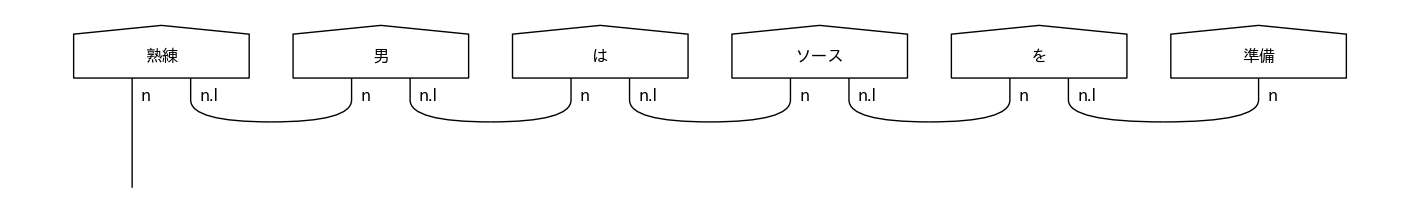

<bound method Diagram.draw of |Ty() @ Word(熟練, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Word(男, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(は, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(ソース, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(を, ('Ty(n) @ Ty(n).l', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Word(準備, ('Ty(n)', {'0'})) @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ Ty(n).l @ Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty()| >> |Ty(n) @ Ty(n).l @ Ty(n) @ [CUP; Ty(n).l @ Ty(n) -> Ty()] @ Ty()| >> |Ty(n) @ [CUP; Ty(n).l @ Ty

In [5]:
raw_train_diagrams[0].draw(figsize=(14,3), fontsize=12)
train_diagrams[0].draw

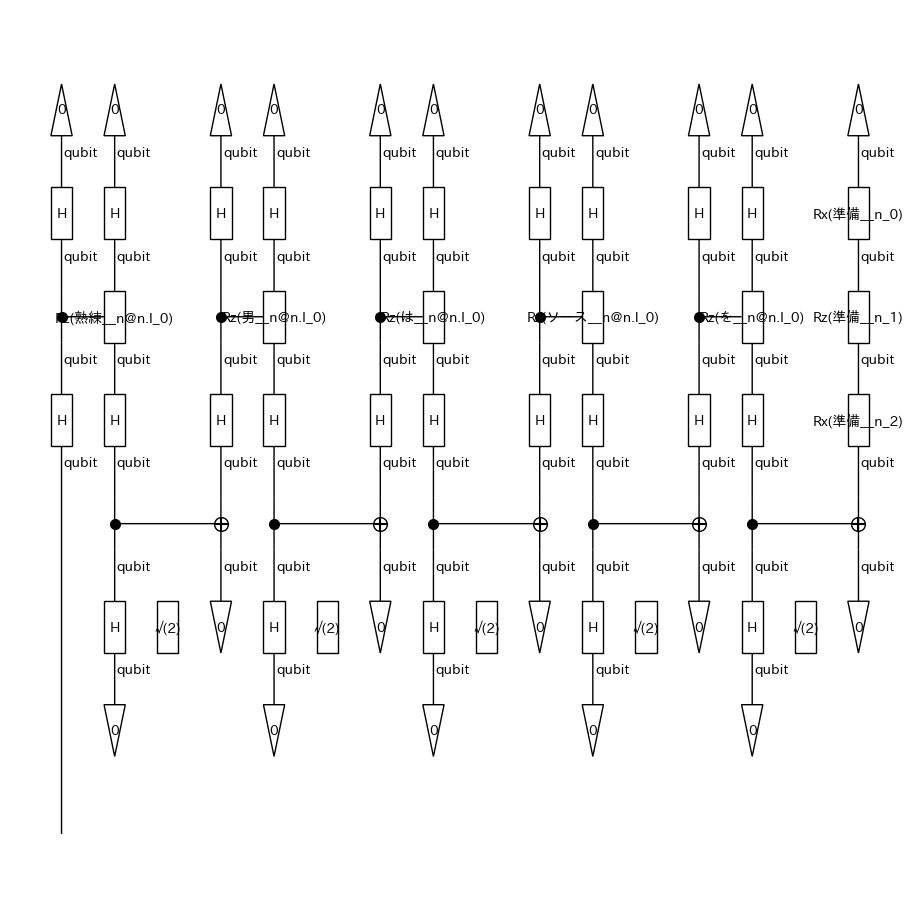

{は__n@n.l_0,
 を__n@n.l_0,
 ソース__n@n.l_0,
 準備__n_0,
 準備__n_1,
 準備__n_2,
 熟練__n@n.l_0,
 男__n@n.l_0}

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9,9))
train_circuits[0].free_symbols

In [7]:
from lambeq import NumpyModel

all_circuits = train_circuits + dev_circuits +test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [8]:
from lambeq import BinaryCrossEntropyLoss

bce = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y:np.sum(np.round(y_hat) == y)/len(y)/2

In [9]:
BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 1000
SEED = 0

In [10]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=0
)

In [11]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [12]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

Epoch 50:    train/loss: 0.6524   valid/loss: 0.7150   train/time: 26.76s   valid/time: 8.89s   train/acc: 0.5571   valid/acc: 0.4667
Epoch 100:   train/loss: 0.7354   valid/loss: 0.8115   train/time: 6.00s   valid/time: 1.28s   train/acc: 0.5571   valid/acc: 0.4667
Epoch 150:   train/loss: 0.7613   valid/loss: 0.8020   train/time: 5.89s   valid/time: 1.24s   train/acc: 0.5000   valid/acc: 0.3667
Epoch 200:   train/loss: 0.7078   valid/loss: 0.8338   train/time: 5.87s   valid/time: 1.26s   train/acc: 0.6143   valid/acc: 0.4667
Epoch 250:   train/loss: 0.7523   valid/loss: 0.9117   train/time: 5.93s   valid/time: 1.26s   train/acc: 0.6429   valid/acc: 0.4333
Epoch 300:   train/loss: 0.6576   valid/loss: 0.8500   train/time: 5.90s   valid/time: 1.25s   train/acc: 0.6571   valid/acc: 0.4333
Epoch 350:   train/loss: 0.7608   valid/loss: 0.8890   train/time: 5.87s   valid/time: 1.24s   train/acc: 0.6571   valid/acc: 0.4667
Epoch 400:   train/loss: 0.5676   valid/loss: 0.9337   train/time: 5

Test accuracy: 0.53333336


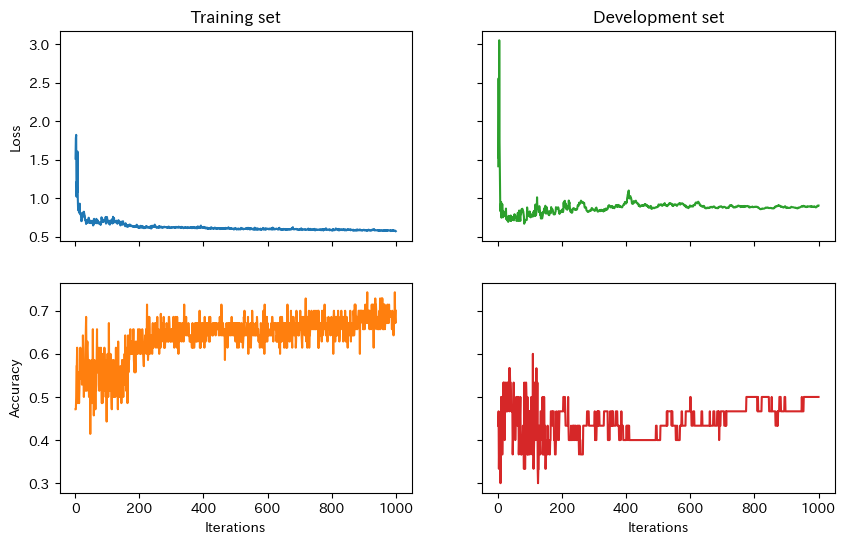

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), np.array(test_labels))
print('Test accuracy:', test_acc)